## Package Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.pandas.set_option('display.max_columns', None) 
sns.set_theme(color_codes = True)

import os
import sys
import tqdm
import random
import warnings
warnings.filterwarnings('ignore')

import time
from datetime import datetime

# ELO
from ELO import ELO

# sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss

# pytorch
import torch
print(torch.cuda.is_available())

# Wandb
import wandb
from CatBoostWandbCallback import CatBoostWandbCallback
# wandb.login(key = 'Personal Key') # Personal Key 입력

# Catboost
from catboost import Pool, CatBoostClassifier

# Optuna
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from optuna.integration import CatBoostPruningCallback

# Seed 고정
SEED = 42
def seed_everything(seed) :
    random.seed(seed)
    np.random.seed(seed)
    # tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    torch.use_deterministic_algorithms(True)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
seed_everything(SEED)

True


## Load Preprocessed Data

In [2]:
data = pd.read_parquet('/data/ephemeral/data/Feature_Selection.parquet')
data

,userID,assessmentItemID,answerCode,KnowledgeTag,testID,testCode,testNum,problemID,problemID_Norm,total_problem,year,quarter,month,day,hour,dow,weekday,LagTime,ElapsedTime,ElapsedTime_Rolling2,ElapsedTime_Rolling3,ElapsedTime_Rolling4,ElapsedTime_Rolling5,user_ElaspedTime_avg,item_ElaspedTime_avg,testID_ElaspedTime_avg,testCode_ElaspedTime_avg,testNum_ElaspedTime_avg,problemID_ElaspedTime_avg,tag_ElaspedTime_avg,Real_Solved,Correct_User_ElapsedTime,Wrong_User_ElapsedTime,user_sum,user_cnt,user_acc,user_itemID_sum,user_itemID_cnt,user_itemID_acc,user_testID_sum,user_testID_cnt,user_testID_acc,user_testCode_sum,user_testCode_cnt,user_testCode_acc,user_testNum_sum,user_testNum_cnt,user_testNum_acc,user_problemID_sum,user_problemID_cnt,user_problemID_acc,user_tag_sum,user_tag_cnt,user_tag_acc,itemID_sum,itemID_cnt,itemID_acc,testID_sum,testID_cnt,testID_acc,testCode_sum,testCode_cnt,testCode_acc,testNum_sum,testNum_cnt,testNum_acc,problemID_sum,problemID_cnt,problemID_acc,tag_sum,tag_cnt,tag_acc,itemID_high_freq,testID_high_freq,testCode_high_freq,testNum_high_freq,problemID_high_freq,tag_high_freq,user_past_solved,relative_correct_rate,is_correct_before1,correct_rate_before1,relative_correct_rate_before1,is_correct_before2,correct_rate_before2,relative_correct_rate_before2,is_correct_before3,correct_rate_before3,relative_correct_rate_before3,is_correct_before4,correct_rate_before4,relative_correct_rate_before4,is_correct_before5,correct_rate_before5,relative_correct_rate_before5,theta,beta
0,0,A060001001,1,7224,060001,6,1,1,0.000000,7,2020,1,3,24,0,1,1,0.000000,0.0,0.0,0.000000,0.00,0.0,38.262057,0.079794,18.804632,66.971222,37.934893,3.989678,13.583961,0,0.081091,0.000000,0,0,0.000000,0,0,0.0,0,0,0.00,0,0,0.00,0,0,0.00,0,0,0.0,0,0,0.00,246,250,0.984000,1429,1500,0.952667,210971,296350,0.711898,11867,16750,0.708478,310634,414350,0.749690,718,750,0.957333,0,0,1,1,1,0,0,0.016000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.0,1.0,0.578202,-3.342176
1,0,A060001002,1,7225,060001,6,1,2,0.083333,7,2020,1,3,24,0,1,1,0.000000,3.0,1.5,0.000000,0.00,0.0,38.262057,13.660000,18.804632,66.971222,37.934893,73.232491,28.919573,0,11.363636,83.125000,1,1,1.000000,0,0,0.0,1,1,1.00,1,1,1.00,1,1,1.00,0,0,0.0,0,0,0.00,242,250,0.968000,1429,1500,0.952667,210971,296350,0.711898,11867,16750,0.708478,297842,413500,0.720295,3439,3750,0.917067,0,0,1,1,1,1,0,0.032000,1,0.984000,0.016000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.0,1.0,0.578202,-3.003042
2,0,A060001003,1,7225,060001,6,1,3,0.166667,7,2020,1,3,24,0,1,1,0.000000,8.0,5.5,3.666667,0.00,0.0,38.262057,26.112000,18.804632,66.971222,37.934893,73.933021,28.919573,0,24.637555,42.190476,2,2,1.000000,0,0,0.0,2,2,1.00,2,2,1.00,2,2,1.00,0,0,0.0,1,1,1.00,229,250,0.916000,1429,1500,0.952667,210971,296350,0.711898,11867,16750,0.708478,285143,414250,0.688336,3439,3750,0.917067,0,0,1,1,1,1,0,0.084000,1,0.968000,0.032000,1,0.984000,0.016000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.0,1.0,0.578202,-2.298332
3,0,A060001004,1,7225,060001,6,1,4,0.250000,7,2020,1,3,24,0,1,1,0.000000,7.0,7.5,6.000000,4.50,0.0,38.262057,19.180000,18.804632,66.971222,37.934893,70.596414,28.919573,0,19.572016,5.571429,3,3,1.000000,0,0,0.0,3,3,1.00,3,3,1.00,3,3,1.00,0,0,0.0,2,2,1.00,243,250,0.972000,1429,1500,0.952667,210971,296350,0.711898,11867,16750,0.708478,273382,412050,0.663468,3439,3750,0.917067,0,0,1,1,1,1,0,0.028000,1,0.916000,0.084000,1,0.968000,0.032000,1,0.984000,0.016000,1,1.000000,1.000000,1,1.0,1.0,0.578202,-3.064188
4,0,A060001005,1,7225,060001,6,1,5,0.333333,7,2020,1,3,24,0,1,1,0.000000,7.0,7.0,7.333333,6.25,5.0,38.262057,18.076000,18.804632,66.971222,37.934893,69.928460,28.919573,0,18.569620,9.076923,4,4,1.000000,0,0,0.0,4,4,1.00,4,4,1.00,4,4,1.00,0,0,0.0,3,3,1.00,237,250,0.948000,1429,1500,0.952667,210971,296350,0.711898,11867,16750,0.708478,240452,401900,0.598288,3439,3750,0.917067,0,0,1,1,1,1,0,0.052000,1,0.972000,0.028000,1,0.916000,0.084000,1,0.968000,0.03

In [3]:
data_dtype = data.dtypes.to_frame().T
data_isnull = data.isnull().sum().to_frame().T
print(f'Row 개수 : {data.shape[0]} / Columns 개수 : {data.shape[1]}')

data_info = pd.concat([data_dtype, data_isnull], axis = 0).set_index(pd.Index(['Dtype', 'Null']))
data_info

Row 개수 : 2526700 / Columns 개수 : 97


,userID,assessmentItemID,answerCode,KnowledgeTag,testID,testCode,testNum,problemID,problemID_Norm,total_problem,year,quarter,month,day,hour,dow,weekday,LagTime,ElapsedTime,ElapsedTime_Rolling2,ElapsedTime_Rolling3,ElapsedTime_Rolling4,ElapsedTime_Rolling5,user_ElaspedTime_avg,item_ElaspedTime_avg,testID_ElaspedTime_avg,testCode_ElaspedTime_avg,testNum_ElaspedTime_avg,problemID_ElaspedTime_avg,tag_ElaspedTime_avg,Real_Solved,Correct_User_ElapsedTime,Wrong_User_ElapsedTime,user_sum,user_cnt,user_acc,user_itemID_sum,user_itemID_cnt,user_itemID_acc,user_testID_sum,user_testID_cnt,user_testID_acc,user_testCode_sum,user_testCode_cnt,user_testCode_acc,user_testNum_sum,user_testNum_cnt,user_testNum_acc,user_problemID_sum,user_problemID_cnt,user_problemID_acc,user_tag_sum,user_tag_cnt,user_tag_acc,itemID_sum,itemID_cnt,itemID_acc,testID_sum,testID_cnt,testID_acc,testCode_sum,testCode_cnt,testCode_acc,testNum_sum,testNum_cnt,testNum_acc,problemID_sum,problemID_cnt,problemID_acc,tag_sum,tag_cnt,tag_acc,itemID_high_freq,testID_high_freq,testCode_high_freq,testNum_high_freq,problemID_high_freq,tag_high_freq,user_past_solved,relative_correct_rate,is_correct_before1,correct_rate_before1,relative_correct_rate_before1,is_correct_before2,correct_rate_before2,relative_correct_rate_before2,is_correct_before3,correct_rate_before3,relative_correct_rate_before3,is_correct_before4,correct_rate_before4,relative_correct_rate_before4,is_correct_before5,correct_rate_before5,relative_correct_rate_before5,theta,beta
Dtype,int16,object,int8,int16,object,int8,int32,int8,float64,int8,int32,int8,int8,int8,int8,int8,int8,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int8,float64,float64,int32,int32,float64,int32,int32,float64,int32,int32,float64,int32,int32,float64,int32,int32,float64,int32,int32,float64,int32,int32,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,int8,int8,int8,int8,int8,int8,int8,float64,int8,float64,float64,int8,float64,float64,int8,float64,float64,int8,float64,float64,int8,float64,float64,float64,float64
Null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
use_col = [
    'userID', 'assessmentItemID', 'KnowledgeTag', 'testID',
    'testCode', 'testNum', 'problemID', 'total_problem', # 'problemID_Norm'
    
    'year', 'quarter', 'month', 'day', 'hour', 'dow', 'weekday', 'ElapsedTime', 'LagTime',
    'ElapsedTime_Rolling2', 'ElapsedTime_Rolling3', 'ElapsedTime_Rolling4', 'ElapsedTime_Rolling5',
    'user_ElaspedTime_avg', 'item_ElaspedTime_avg', 'testID_ElaspedTime_avg', 'testCode_ElaspedTime_avg',
    'testNum_ElaspedTime_avg', 'problemID_ElaspedTime_avg', 'tag_ElaspedTime_avg',
    'Real_Solved', 'Correct_User_ElapsedTime', 'Wrong_User_ElapsedTime',
    
    'user_sum', 'user_cnt', 'user_acc', 'user_itemID_sum', 'user_itemID_cnt', 'user_itemID_acc',
    'user_testID_sum', 'user_testID_cnt', 'user_testID_acc', 'user_testCode_sum', 'user_testCode_cnt', 'user_testCode_acc',
    'user_testNum_sum', 'user_testNum_cnt', 'user_testNum_acc', 'user_problemID_sum', 'user_problemID_cnt', 'user_problemID_acc',
    'user_tag_sum', 'user_tag_cnt', 'user_tag_acc',
    
    'itemID_sum', 'itemID_cnt', 'itemID_acc', 'testID_sum', 'testID_cnt', 'testID_acc',
    'testCode_sum', 'testCode_cnt', 'testCode_acc', 'testNum_sum', 'testNum_cnt', 'testNum_acc',
    'problemID_sum', 'problemID_cnt', 'problemID_acc', 'tag_sum', 'tag_cnt', 'tag_acc',
    'itemID_high_freq', 'testID_high_freq', 'testCode_high_freq',
    'testNum_high_freq', 'problemID_high_freq', 'tag_high_freq',

    'user_past_solved',
    # 'relative_correct_rate',
    'is_correct_before1', 'correct_rate_before1', 'relative_correct_rate_before1',
    'is_correct_before2', 'correct_rate_before2', 'relative_correct_rate_before2',
    'is_correct_before3', 'correct_rate_before3', 'relative_correct_rate_before3',
    'is_correct_before4', 'correct_rate_before4', 'relative_correct_rate_before4',
    'is_correct_before5', 'correct_rate_before5', 'relative_correct_rate_before5',
    
    'theta', 'beta'
]
print(len(use_col))

94


In [5]:
from sklearn.feature_selection import VarianceThreshold
feats = data.drop(columns = ['answerCode'])
feats['assessmentItemID'] = feats['assessmentItemID'].map({v : (k+1) for k, v in enumerate(feats['assessmentItemID'].unique())})
feats['testID'] = feats['testID'].map({v : (k+1) for k, v in enumerate(feats['testID'].unique())})
selector = VarianceThreshold(threshold = 0.8)
selector.fit_transform(feats)
feats_filtered = selector.get_feature_names_out()
print(len(feats_filtered), feats_filtered)

53 ['userID' 'assessmentItemID' 'KnowledgeTag' 'testID' 'testCode' 'testNum'
 'problemID' 'total_problem' 'quarter' 'month' 'day' 'hour' 'dow'
 'LagTime' 'ElapsedTime' 'ElapsedTime_Rolling2' 'ElapsedTime_Rolling3'
 'ElapsedTime_Rolling4' 'ElapsedTime_Rolling5' 'user_ElaspedTime_avg'
 'item_ElaspedTime_avg' 'testID_ElaspedTime_avg'
 'testCode_ElaspedTime_avg' 'testNum_ElaspedTime_avg'
 'problemID_ElaspedTime_avg' 'tag_ElaspedTime_avg'
 'Correct_User_ElapsedTime' 'Wrong_User_ElapsedTime' 'user_sum' 'user_cnt'
 'user_testID_sum' 'user_testID_cnt' 'user_testCode_sum'
 'user_testCode_cnt' 'user_testNum_sum' 'user_testNum_cnt'
 'user_problemID_sum' 'user_problemID_cnt' 'user_tag_sum' 'user_tag_cnt'
 'itemID_sum' 'itemID_cnt' 'testID_sum' 'testID_cnt' 'testCode_sum'
 'testCode_cnt' 'testNum_sum' 'testNum_cnt' 'problemID_sum'
 'problemID_cnt' 'tag_sum' 'tag_cnt' 'beta']


## Data Split

In [6]:
train_data = data[data['answerCode'] != -1]
valid_indices = set(data[data['answerCode'] != -1].index).intersection(set(data.reset_index().groupby('userID', as_index = False).last().set_index('index').index))

train_df = train_data.loc[~train_data.index.isin(valid_indices)]
valid_df = train_data.loc[train_data.index.isin(valid_indices)]
test_df = data[data['answerCode'] == -1].drop(columns = 'answerCode')
print(train_df.shape, valid_df.shape, test_df.shape)

(2519258, 97) (6698, 97) (744, 96)


In [7]:
cat_col = ['userID', 'assessmentItemID', 'KnowledgeTag', 'testID', 'testCode', 'testNum', 'problemID', 'total_problem',
           'year', 'quarter', 'month', 'day', 'hour', 'dow', 'weekday', 'Real_Solved', 
           'itemID_high_freq', 'testID_high_freq', 'testCode_high_freq',
           'testNum_high_freq', 'problemID_high_freq', 'tag_high_freq',
           'user_past_solved', 'is_correct_before1', 'is_correct_before2',
           'is_correct_before3', 'is_correct_before4', 'is_correct_before5']

for col in tqdm.tqdm(cat_col) :
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')

100%|██████████| 28/28 [00:01<00:00, 24.90it/s]


In [8]:
X_train, y_train = train_df[use_col], train_df['answerCode'] # use_col
X_valid, y_valid = valid_df[use_col], valid_df['answerCode'] # feats_filtered
test_df = test_df[use_col]
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, test_df.shape)

(2519258, 94) (2519258,) (6698, 94) (6698,) (744, 94)


## CatboostClassifier

### Optuna HPO

In [78]:
def objective_CAT_CLF(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-3, 0.01, 0.05, 0.1, 0.5]),
        'depth' : trial.suggest_int('depth', 1, 15),
        # 'colsample_bylevel' : trial.suggest_categorical('colsample_bylevel', [1e-3, 0.01, 0.1, 0.5]),
        'boosting_type' : trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type' : trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'l2_leaf_reg' : trial.suggest_categorical('l2_leaf_reg', [1e-3, 1, 3, 5]),
        'random_strength' : trial.suggest_categorical('random_strength', [1e-5, 1e-3, 0.1, 1]),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 1, 10),
    }

    if param['bootstrap_type'] == 'Bayesian' :
        param['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    elif param['bootstrap_type'] == 'Bernoulli' :
        param['subsample'] = trial.suggest_float('subsample', 0.1, 1)
        
    train_data = Pool(data = X_train, label = y_train, cat_features = cat_col)
    valid_data = Pool(data = X_valid, label = y_valid, cat_features = cat_col)
    
    model = CatBoostClassifier(**param, iterations = 5000, loss_function = 'Logloss', eval_metric = 'AUC',
                               use_best_model = True, random_state = SEED, # task_type = 'GPU', devices = '0',
                               cat_features = [X_train.columns.get_loc(col) for col in X_train.select_dtypes('category').columns])
    pruning_callback = CatBoostPruningCallback(trial, 'AUC', eval_set_index = 1)
    cat_model = model.fit(train_data, eval_set = [train_data, valid_data], verbose = 300,
                          early_stopping_rounds = 100, callbacks = [pruning_callback])
    pruning_callback.check_pruned()
    
    proba = cat_model.predict_proba(X_valid)
    # score = log_loss(y_valid, proba[:, 1])
    # score = accuracy_score(y_valid, np.where(proba[:, 1] >= 0.5, 1, 0))
    score = roc_auc_score(y_valid, proba[:, 1]) # pred
    return score

In [10]:
# Study Optuna
study = optuna.create_study(direction = 'maximize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objective_CAT_CLF(trial, X_train, y_train, X_valid, y_valid), show_progress_bar = True, n_trials = 100)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n')

[I 2024-01-20 01:00:04,936] A new study created in memory with name: no-name-4c731d96-8136-4a53-a659-838c6543caa7
  0%|          | 0/100 [00:00<?, ?it/s]

0:	test: 0.7856278	test1: 0.7383691	best: 0.7383691 (0)	total: 1.55s	remaining: 2h 8m 51s
300:	test: 0.8374227	test1: 0.8087141	best: 0.8087141 (300)	total: 5m 36s	remaining: 1h 27m 27s
600:	test: 0.8538063	test1: 0.8177996	best: 0.8177996 (600)	total: 11m 32s	remaining: 1h 24m 26s
900:	test: 0.8589423	test1: 0.8218501	best: 0.8218501 (900)	total: 17m 24s	remaining: 1h 19m 13s
1200:	test: 0.8618947	test1: 0.8238121	best: 0.8238121 (1200)	total: 23m 17s	remaining: 1h 13m 40s
1500:	test: 0.8652326	test1: 0.8250125	best: 0.8250253 (1499)	total: 29m 31s	remaining: 1h 8m 49s
1800:	test: 0.8685800	test1: 0.8263182	best: 0.8263268 (1796)	total: 36m 8s	remaining: 1h 4m 11s
2100:	test: 0.8709164	test1: 0.8273673	best: 0.8273673 (2100)	total: 42m 22s	remaining: 58m 27s
2400:	test: 0.8730106	test1: 0.8280239	best: 0.8280295 (2399)	total: 49m	remaining: 53m 2s
2700:	test: 0.8745757	test1: 0.8286314	best: 0.8286314 (2700)	total: 55m 34s	remaining: 47m 18s
3000:	test: 0.8760059	test1: 0.8290788	best

Best trial: 0. Best value: 0.830799:   1%|          | 1/100 [1:48:50<179:34:32, 6530.03s/it]

[I 2024-01-20 02:48:54,953] Trial 0 finished with value: 0.830799076806551 and parameters: {'learning_rate': 0.01, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'l2_leaf_reg': 0.001, 'random_strength': 0.1, 'min_data_in_leaf': 3, 'subsample': 0.6506676052501416}. Best is trial 0 with value: 0.830799076806551.
0:	test: 0.7856278	test1: 0.7383691	best: 0.7383691 (0)	total: 1.25s	remaining: 1h 44m 31s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8312637104
bestIteration = 152

Shrink model to first 153 iterations.


Best trial: 1. Best value: 0.831264:   2%|▏         | 2/100 [1:54:27<78:36:28, 2887.64s/it] 

[I 2024-01-20 02:54:32,924] Trial 1 finished with value: 0.831263710351628 and parameters: {'learning_rate': 0.5, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'l2_leaf_reg': 3, 'random_strength': 0.1, 'min_data_in_leaf': 2, 'subsample': 0.5456592191001431}. Best is trial 1 with value: 0.831263710351628.
0:	test: 0.8166140	test1: 0.7847198	best: 0.7847198 (0)	total: 5.93s	remaining: 8h 14m 15s
300:	test: 0.8481404	test1: 0.8204620	best: 0.8204620 (300)	total: 28m 48s	remaining: 7h 29m 47s
600:	test: 0.8501590	test1: 0.8220696	best: 0.8220696 (600)	total: 57m 38s	remaining: 7h 1m 57s
900:	test: 0.8517861	test1: 0.8230305	best: 0.8230305 (900)	total: 1h 26m 50s	remaining: 6h 35m 3s
1200:	test: 0.8526526	test1: 0.8237490	best: 0.8237490 (1200)	total: 1h 55m 40s	remaining: 6h 5m 55s
1500:	test: 0.8533604	test1: 0.8244459	best: 0.8244459 (1500)	total: 2h 24m 36s	remaining: 5h 37m 5s
1800:	test: 0.8539312	test1: 0.8249667	best: 0.8249674 (1798)	total: 2h 53m 44s	remain

Best trial: 1. Best value: 0.831264:   3%|▎         | 3/100 [10:01:48<402:02:13, 14920.96s/it]

[I 2024-01-20 11:01:53,540] Trial 2 finished with value: 0.8279779598282231 and parameters: {'learning_rate': 0.01, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'l2_leaf_reg': 3, 'random_strength': 1, 'min_data_in_leaf': 3, 'bagging_temperature': 8.287375091519294}. Best is trial 1 with value: 0.831263710351628.
0:	test: 0.7562063	test1: 0.7103322	best: 0.7103322 (0)	total: 1.39s	remaining: 1h 55m 39s


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8249936584
bestIteration = 107

Shrink model to first 108 iterations.


Best trial: 1. Best value: 0.831264:   4%|▍         | 4/100 [10:05:25<243:05:48, 9116.13s/it] 

[I 2024-01-20 11:05:30,870] Trial 3 finished with value: 0.8249936584041329 and parameters: {'learning_rate': 0.5, 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 3, 'random_strength': 0.1, 'min_data_in_leaf': 4}. Best is trial 1 with value: 0.831263710351628.
0:	test: 0.8370776	test1: 0.8108981	best: 0.8108981 (0)	total: 29.7s	remaining: 1d 17h 15m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8328671069
bestIteration = 46

Shrink model to first 47 iterations.


Best trial: 4. Best value: 0.832867:   5%|▌         | 5/100 [10:39:36<173:19:50, 6568.32s/it]

[I 2024-01-20 11:39:41,656] Trial 4 finished with value: 0.832867106946102 and parameters: {'learning_rate': 0.1, 'depth': 14, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'l2_leaf_reg': 0.001, 'random_strength': 1, 'min_data_in_leaf': 4, 'subsample': 0.5577136220482325}. Best is trial 4 with value: 0.832867106946102.


Best trial: 4. Best value: 0.832867:   6%|▌         | 6/100 [10:39:48<113:17:53, 4339.08s/it]

0:	test: 0.7557456	test1: 0.7124401	best: 0.7124401 (0)	total: 1.38s	remaining: 1h 55m 12s

bestTest = 0.7124401121
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 11:39:53,403] Trial 5 pruned. Trial was pruned at iteration 0.
0:	test: 0.8171626	test1: 0.7946844	best: 0.7946844 (0)	total: 3.13s	remaining: 4h 20m 42s


Best trial: 4. Best value: 0.832867:   7%|▋         | 7/100 [10:40:19<75:42:44, 2930.80s/it] 


bestTest = 0.8056279877
bestIteration = 6

Shrink model to first 7 iterations.
[I 2024-01-20 11:40:24,814] Trial 6 pruned. Trial was pruned at iteration 6.
0:	test: 0.7972000	test1: 0.7610458	best: 0.7610458 (0)	total: 1.81s	remaining: 2h 30m 45s
300:	test: 0.8767337	test1: 0.8329207	best: 0.8330187 (287)	total: 8m 39s	remaining: 2h 15m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8341344883
bestIteration = 471

Shrink model to first 472 iterations.


Best trial: 7. Best value: 0.834134:   8%|▊         | 8/100 [10:56:59<59:11:22, 2316.12s/it]

[I 2024-01-20 11:57:04,781] Trial 7 finished with value: 0.8341344882778727 and parameters: {'learning_rate': 0.5, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'l2_leaf_reg': 0.001, 'random_strength': 0.001, 'min_data_in_leaf': 9, 'bagging_temperature': 3.2078006497173583}. Best is trial 7 with value: 0.8341344882778727.
0:	test: 0.8267180	test1: 0.7975335	best: 0.7975335 (0)	total: 3.72s	remaining: 5h 9m 58s
300:	test: 0.9058765	test1: 0.8386895	best: 0.8388697 (294)	total: 20m 22s	remaining: 5h 18m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8410956849
bestIteration = 490

Shrink model to first 491 iterations.


Best trial: 8. Best value: 0.841096:   9%|▉         | 9/100 [11:36:10<58:48:56, 2326.78s/it]

[I 2024-01-20 12:36:15,000] Trial 8 finished with value: 0.8410956848566263 and parameters: {'learning_rate': 0.1, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'l2_leaf_reg': 0.001, 'random_strength': 1e-05, 'min_data_in_leaf': 9, 'subsample': 0.5996807304395161}. Best is trial 8 with value: 0.8410956848566263.
0:	test: 0.8333079	test1: 0.8048231	best: 0.8048231 (0)	total: 4.46s	remaining: 6h 11m 57s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8337099586
bestIteration = 23

Shrink model to first 24 iterations.


Best trial: 8. Best value: 0.841096:  10%|█         | 10/100 [11:45:17<44:26:09, 1777.44s/it]

[I 2024-01-20 12:45:22,375] Trial 9 finished with value: 0.8337099586277859 and parameters: {'learning_rate': 0.5, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'l2_leaf_reg': 0.001, 'random_strength': 1e-05, 'min_data_in_leaf': 7, 'subsample': 0.10455542546159682}. Best is trial 8 with value: 0.8410956848566263.
0:	test: 0.8365620	test1: 0.8075560	best: 0.8075560 (0)	total: 7.23s	remaining: 10h 2m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8411109583
bestIteration = 112

Shrink model to first 113 iterations.


Best trial: 10. Best value: 0.841111:  11%|█         | 11/100 [12:13:47<43:26:07, 1756.93s/it]

[I 2024-01-20 13:13:52,821] Trial 10 finished with value: 0.8411109582776584 and parameters: {'learning_rate': 0.1, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 1, 'random_strength': 1e-05, 'min_data_in_leaf': 10}. Best is trial 10 with value: 0.8411109582776584.
0:	test: 0.8365620	test1: 0.8075560	best: 0.8075560 (0)	total: 7.25s	remaining: 10h 3m 51s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8411109583
bestIteration = 112

Shrink model to first 113 iterations.


Best trial: 10. Best value: 0.841111:  12%|█▏        | 12/100 [12:42:10<42:32:43, 1740.50s/it]

[I 2024-01-20 13:42:15,725] Trial 11 finished with value: 0.8411109582776584 and parameters: {'learning_rate': 0.1, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 1, 'random_strength': 1e-05, 'min_data_in_leaf': 10}. Best is trial 10 with value: 0.8411109582776584.
0:	test: 0.8384170	test1: 0.8099137	best: 0.8099137 (0)	total: 8.26s	remaining: 11h 28m 34s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.840326744
bestIteration = 92

Shrink model to first 93 iterations.


Best trial: 10. Best value: 0.841111:  13%|█▎        | 13/100 [13:11:18<42:06:54, 1742.69s/it]

[I 2024-01-20 14:11:23,460] Trial 12 finished with value: 0.8403267440281816 and parameters: {'learning_rate': 0.1, 'depth': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 1, 'random_strength': 1e-05, 'min_data_in_leaf': 10}. Best is trial 10 with value: 0.8411109582776584.
0:	test: 0.8349060	test1: 0.8059446	best: 0.8059446 (0)	total: 6.23s	remaining: 8h 39m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8423748115
bestIteration = 168

Shrink model to first 169 iterations.


Best trial: 13. Best value: 0.842375:  14%|█▍        | 14/100 [13:42:33<42:35:15, 1782.74s/it]

[I 2024-01-20 14:42:38,742] Trial 13 finished with value: 0.8423748115384891 and parameters: {'learning_rate': 0.1, 'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 1, 'random_strength': 1e-05, 'min_data_in_leaf': 7}. Best is trial 13 with value: 0.8423748115384891.
0:	test: 0.8349060	test1: 0.8059446	best: 0.8059446 (0)	total: 6.24s	remaining: 8h 39m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.840332907
bestIteration = 138

Shrink model to first 139 iterations.


Best trial: 13. Best value: 0.842375:  15%|█▌        | 15/100 [14:10:29<41:20:01, 1750.61s/it]

[I 2024-01-20 15:10:34,882] Trial 14 finished with value: 0.8403329069875456 and parameters: {'learning_rate': 0.1, 'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 1, 'random_strength': 0.001, 'min_data_in_leaf': 7}. Best is trial 13 with value: 0.8423748115384891.
0:	test: 0.8414064	test1: 0.8118048	best: 0.8118048 (0)	total: 12.2s	remaining: 16h 54m


Best trial: 13. Best value: 0.842375:  16%|█▌        | 16/100 [14:11:27<28:57:20, 1240.96s/it]


bestTest = 0.8126517071
bestIteration = 3

Shrink model to first 4 iterations.
[I 2024-01-20 15:11:32,319] Trial 15 pruned. Trial was pruned at iteration 3.


Best trial: 13. Best value: 0.842375:  17%|█▋        | 17/100 [14:11:43<20:07:18, 872.75s/it] 

0:	test: 0.8335362	test1: 0.8040776	best: 0.8040776 (0)	total: 5.55s	remaining: 7h 42m 5s

bestTest = 0.8040775568
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 15:11:48,773] Trial 16 pruned. Trial was pruned at iteration 0.


Best trial: 13. Best value: 0.842375:  18%|█▊        | 18/100 [14:11:57<13:59:57, 614.61s/it]

0:	test: 0.8128194	test1: 0.7875460	best: 0.7875460 (0)	total: 2.75s	remaining: 3h 49m 14s

bestTest = 0.7875459989
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 15:12:02,447] Trial 17 pruned. Trial was pruned at iteration 0.


Best trial: 13. Best value: 0.842375:  19%|█▉        | 19/100 [14:12:13<9:47:08, 434.92s/it] 

0:	test: 0.8329348	test1: 0.8044401	best: 0.8044401 (0)	total: 5.43s	remaining: 7h 32m 26s

bestTest = 0.8044400996
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 15:12:18,773] Trial 18 pruned. Trial was pruned at iteration 0.
0:	test: 0.8365620	test1: 0.8075560	best: 0.8075560 (0)	total: 7.11s	remaining: 9h 52m 5s


Best trial: 13. Best value: 0.842375:  20%|██        | 20/100 [14:14:24<7:38:08, 343.60s/it]


bestTest = 0.825659124
bestIteration = 15

Shrink model to first 16 iterations.
[I 2024-01-20 15:14:29,542] Trial 19 pruned. Trial was pruned at iteration 16.
0:	test: 0.8413477	test1: 0.8117490	best: 0.8117490 (0)	total: 12.2s	remaining: 16h 53m 17s


Best trial: 13. Best value: 0.842375:  21%|██        | 21/100 [14:15:22<5:39:34, 257.91s/it]


bestTest = 0.8125586374
bestIteration = 3

Shrink model to first 4 iterations.
[I 2024-01-20 15:15:27,654] Trial 20 pruned. Trial was pruned at iteration 3.
0:	test: 0.8384170	test1: 0.8099137	best: 0.8099137 (0)	total: 8.37s	remaining: 11h 37m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.840326744
bestIteration = 92

Shrink model to first 93 iterations.


Best trial: 13. Best value: 0.842375:  22%|██▏       | 22/100 [14:44:21<15:13:05, 702.37s/it]

[I 2024-01-20 15:44:26,536] Trial 21 finished with value: 0.8403267440281816 and parameters: {'learning_rate': 0.1, 'depth': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 1, 'random_strength': 1e-05, 'min_data_in_leaf': 10}. Best is trial 13 with value: 0.8423748115384891.
0:	test: 0.8365620	test1: 0.8075560	best: 0.8075560 (0)	total: 7.19s	remaining: 9h 59m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8411109583
bestIteration = 112

Shrink model to first 113 iterations.


Best trial: 13. Best value: 0.842375:  23%|██▎       | 23/100 [15:12:48<21:28:02, 1003.67s/it]

[I 2024-01-20 16:12:52,945] Trial 22 finished with value: 0.8411109582776584 and parameters: {'learning_rate': 0.1, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 1, 'random_strength': 1e-05, 'min_data_in_leaf': 10}. Best is trial 13 with value: 0.8423748115384891.
0:	test: 0.8349060	test1: 0.8059446	best: 0.8059446 (0)	total: 6.28s	remaining: 8h 43m 14s


Best trial: 13. Best value: 0.842375:  23%|██▎       | 23/100 [15:15:26<21:28:02, 1003.67s/it]


bestTest = 0.8270397163
bestIteration = 22

Shrink model to first 23 iterations.
[I 2024-01-20 16:15:31,733] Trial 23 pruned. Trial was pruned at iteration 22.


Best trial: 13. Best value: 0.842375:  25%|██▌       | 25/100 [15:15:41<11:02:01, 529.63s/it] 

0:	test: 0.8314476	test1: 0.8006151	best: 0.8006151 (0)	total: 4.55s	remaining: 6h 19m 17s

bestTest = 0.8006151348
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 16:15:46,890] Trial 24 pruned. Trial was pruned at iteration 0.


Best trial: 13. Best value: 0.842375:  26%|██▌       | 26/100 [15:16:01<7:44:35, 376.69s/it] 

0:	test: 0.8120658	test1: 0.7785981	best: 0.7785981 (0)	total: 9.07s	remaining: 12h 35m 50s

bestTest = 0.7785980518
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 16:16:06,778] Trial 25 pruned. Trial was pruned at iteration 0.
0:	test: 0.8365620	test1: 0.8075560	best: 0.8075560 (0)	total: 7.12s	remaining: 9h 52m 49s


Best trial: 13. Best value: 0.842375:  27%|██▋       | 27/100 [15:16:34<5:32:35, 273.36s/it]


bestTest = 0.8094353568
bestIteration = 2

Shrink model to first 3 iterations.
[I 2024-01-20 16:16:39,056] Trial 26 pruned. Trial was pruned at iteration 2.
0:	test: 0.8380403	test1: 0.8129319	best: 0.8129319 (0)	total: 30.8s	remaining: 1d 18h 43m 41s


Best trial: 13. Best value: 0.842375:  28%|██▊       | 28/100 [15:24:52<6:48:57, 340.80s/it]


bestTest = 0.8256069622
bestIteration = 14

Shrink model to first 15 iterations.
[I 2024-01-20 16:24:57,208] Trial 27 pruned. Trial was pruned at iteration 16.
0:	test: 0.8349060	test1: 0.8059446	best: 0.8059446 (0)	total: 6.22s	remaining: 8h 38m 42s


Best trial: 13. Best value: 0.842375:  29%|██▉       | 29/100 [15:25:14<4:50:09, 245.20s/it]


bestTest = 0.8086899513
bestIteration = 1

Shrink model to first 2 iterations.
[I 2024-01-20 16:25:19,344] Trial 28 pruned. Trial was pruned at iteration 1.


Best trial: 13. Best value: 0.842375:  30%|███       | 30/100 [15:25:28<3:25:03, 175.77s/it]

0:	test: 0.8138374	test1: 0.7890284	best: 0.7890284 (0)	total: 2.9s	remaining: 4h 1m 34s

bestTest = 0.7890283693
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 16:25:33,108] Trial 29 pruned. Trial was pruned at iteration 0.


Best trial: 13. Best value: 0.842375:  31%|███       | 31/100 [15:25:43<2:26:48, 127.65s/it]

0:	test: 0.8314476	test1: 0.8006151	best: 0.8006151 (0)	total: 4.46s	remaining: 6h 12m 3s

bestTest = 0.8006151348
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 16:25:48,505] Trial 30 pruned. Trial was pruned at iteration 0.
0:	test: 0.8365620	test1: 0.8075560	best: 0.8075560 (0)	total: 7.11s	remaining: 9h 52m 6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8411109583
bestIteration = 112

Shrink model to first 113 iterations.


Best trial: 13. Best value: 0.842375:  32%|███▏      | 32/100 [15:54:05<11:20:05, 600.09s/it]

[I 2024-01-20 16:54:10,919] Trial 31 finished with value: 0.8411109582776584 and parameters: {'learning_rate': 0.1, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 1, 'random_strength': 1e-05, 'min_data_in_leaf': 10}. Best is trial 13 with value: 0.8423748115384891.
0:	test: 0.8396967	test1: 0.8113513	best: 0.8113513 (0)	total: 10.1s	remaining: 13h 58m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8404573273
bestIteration = 92

Shrink model to first 93 iterations.


Best trial: 13. Best value: 0.842375:  33%|███▎      | 33/100 [16:28:32<19:21:17, 1039.96s/it]

[I 2024-01-20 17:28:37,249] Trial 32 finished with value: 0.8404573273120923 and parameters: {'learning_rate': 0.1, 'depth': 14, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 1, 'random_strength': 1e-05, 'min_data_in_leaf': 10}. Best is trial 13 with value: 0.8423748115384891.
0:	test: 0.8365620	test1: 0.8075560	best: 0.8075560 (0)	total: 7.35s	remaining: 10h 12m 28s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8411109583
bestIteration = 112

Shrink model to first 113 iterations.


Best trial: 13. Best value: 0.842375:  34%|███▍      | 34/100 [16:56:57<22:43:38, 1239.68s/it]

[I 2024-01-20 17:57:02,927] Trial 33 finished with value: 0.8411109582776584 and parameters: {'learning_rate': 0.1, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 1, 'random_strength': 1e-05, 'min_data_in_leaf': 10}. Best is trial 13 with value: 0.8423748115384891.


Best trial: 13. Best value: 0.842375:  35%|███▌      | 35/100 [16:57:14<15:45:33, 872.82s/it] 

0:	test: 0.8349400	test1: 0.8060380	best: 0.8060380 (0)	total: 6.28s	remaining: 8h 43m 23s

bestTest = 0.8060380031
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 17:57:19,739] Trial 34 pruned. Trial was pruned at iteration 0.


Best trial: 13. Best value: 0.842375:  36%|███▌      | 36/100 [16:57:31<10:57:09, 616.09s/it]

0:	test: 0.8314476	test1: 0.8006151	best: 0.8006151 (0)	total: 6.46s	remaining: 8h 57m 58s

bestTest = 0.8006151348
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 17:57:36,782] Trial 35 pruned. Trial was pruned at iteration 0.
0:	test: 0.8373946	test1: 0.8117240	best: 0.8117240 (0)	total: 8.59s	remaining: 11h 55m 21s

bestTest = 0.8337058053
bestIteration = 23

Shrink model to first 24 iterations.


Best trial: 13. Best value: 0.842375:  37%|███▋      | 37/100 [17:04:45<9:49:28, 561.40s/it] 

[I 2024-01-20 18:04:50,577] Trial 36 pruned. Trial was pruned at iteration 44.


Best trial: 13. Best value: 0.842375:  38%|███▊      | 38/100 [17:05:28<6:59:21, 405.83s/it]

0:	test: 0.8315305	test1: 0.8030785	best: 0.8030785 (0)	total: 32s	remaining: 1d 20h 26m 59s

bestTest = 0.8030785322
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 18:05:33,415] Trial 37 pruned. Trial was pruned at iteration 0.


Best trial: 13. Best value: 0.842375:  39%|███▉      | 39/100 [17:05:44<4:53:45, 288.94s/it]

0:	test: 0.8335360	test1: 0.8040776	best: 0.8040776 (0)	total: 5.54s	remaining: 7h 41m 16s

bestTest = 0.8040775568
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 18:05:49,604] Trial 38 pruned. Trial was pruned at iteration 0.


Best trial: 13. Best value: 0.842375:  40%|████      | 40/100 [17:05:56<3:25:49, 205.83s/it]

0:	test: 0.6747601	test1: 0.6540909	best: 0.6540909 (0)	total: 912ms	remaining: 1h 15m 56s

bestTest = 0.6540908652
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 18:06:01,508] Trial 39 pruned. Trial was pruned at iteration 0.


Best trial: 13. Best value: 0.842375:  41%|████      | 41/100 [17:06:10<2:25:53, 148.37s/it]

0:	test: 0.8271466	test1: 0.7999282	best: 0.7999282 (0)	total: 3.9s	remaining: 5h 25m 22s

bestTest = 0.7999282328
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 18:06:15,815] Trial 40 pruned. Trial was pruned at iteration 0.
0:	test: 0.8365620	test1: 0.8075560	best: 0.8075560 (0)	total: 7.23s	remaining: 10h 2m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8411109583
bestIteration = 112

Shrink model to first 113 iterations.


Best trial: 13. Best value: 0.842375:  42%|████▏     | 42/100 [17:34:39<9:55:52, 616.42s/it]

[I 2024-01-20 18:34:44,363] Trial 41 finished with value: 0.8411109582776584 and parameters: {'learning_rate': 0.1, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 1, 'random_strength': 1e-05, 'min_data_in_leaf': 10}. Best is trial 13 with value: 0.8423748115384891.
0:	test: 0.8365620	test1: 0.8075560	best: 0.8075560 (0)	total: 7.17s	remaining: 9h 57m 26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8411109583
bestIteration = 112

Shrink model to first 113 iterations.


Best trial: 13. Best value: 0.842375:  43%|████▎     | 43/100 [18:03:09<14:57:17, 944.52s/it]

[I 2024-01-20 19:03:14,424] Trial 42 finished with value: 0.8411109582776584 and parameters: {'learning_rate': 0.1, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 1, 'random_strength': 1e-05, 'min_data_in_leaf': 10}. Best is trial 13 with value: 0.8423748115384891.
0:	test: 0.8384170	test1: 0.8099137	best: 0.8099137 (0)	total: 8.31s	remaining: 11h 32m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.840326744
bestIteration = 92

Shrink model to first 93 iterations.


Best trial: 13. Best value: 0.842375:  44%|████▍     | 44/100 [18:32:07<18:23:44, 1182.58s/it]

[I 2024-01-20 19:32:12,476] Trial 43 finished with value: 0.8403267440281816 and parameters: {'learning_rate': 0.1, 'depth': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 1, 'random_strength': 1e-05, 'min_data_in_leaf': 9}. Best is trial 13 with value: 0.8423748115384891.


Best trial: 13. Best value: 0.842375:  45%|████▌     | 45/100 [18:32:24<12:43:26, 832.84s/it] 

0:	test: 0.8349060	test1: 0.8059446	best: 0.8059446 (0)	total: 6.26s	remaining: 8h 41m 24s

bestTest = 0.8059445762
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 19:32:29,269] Trial 44 pruned. Trial was pruned at iteration 0.


Best trial: 13. Best value: 0.842375:  46%|████▌     | 46/100 [18:32:46<8:50:46, 589.74s/it] 

0:	test: 0.8260981	test1: 0.7950297	best: 0.7950297 (0)	total: 11.8s	remaining: 16h 21m 56s

bestTest = 0.7950296626
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 19:32:51,777] Trial 45 pruned. Trial was pruned at iteration 0.
0:	test: 0.8364339	test1: 0.8090584	best: 0.8090584 (0)	total: 6.13s	remaining: 8h 30m 50s


Best trial: 13. Best value: 0.842375:  47%|████▋     | 47/100 [18:33:40<6:18:56, 428.99s/it]


bestTest = 0.8214457588
bestIteration = 6

Shrink model to first 7 iterations.
[I 2024-01-20 19:33:45,675] Trial 46 pruned. Trial was pruned at iteration 6.
0:	test: 0.8396636	test1: 0.8116175	best: 0.8116175 (0)	total: 53.2s	remaining: 3d 1h 54m 20s


Best trial: 13. Best value: 0.842375:  48%|████▊     | 48/100 [18:35:39<4:51:03, 335.84s/it]


bestTest = 0.8118358295
bestIteration = 1

Shrink model to first 2 iterations.
[I 2024-01-20 19:35:44,166] Trial 47 pruned. Trial was pruned at iteration 1.


Best trial: 13. Best value: 0.842375:  49%|████▉     | 49/100 [18:35:55<3:23:58, 239.98s/it]

0:	test: 0.8327554	test1: 0.8037394	best: 0.8037394 (0)	total: 5.45s	remaining: 7h 33m 45s

bestTest = 0.8037393979
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 19:36:00,469] Trial 48 pruned. Trial was pruned at iteration 0.


Best trial: 13. Best value: 0.842375:  50%|█████     | 50/100 [18:36:07<2:23:02, 171.64s/it]

0:	test: 0.7976412	test1: 0.7583573	best: 0.7583573 (0)	total: 1.72s	remaining: 2h 23m 23s

bestTest = 0.7583572855
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 19:36:12,654] Trial 49 pruned. Trial was pruned at iteration 0.


Best trial: 13. Best value: 0.842375:  51%|█████     | 51/100 [18:36:21<1:41:34, 124.38s/it]

0:	test: 0.8176054	test1: 0.7946863	best: 0.7946863 (0)	total: 3.28s	remaining: 4h 33m 14s

bestTest = 0.7946862786
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 19:36:26,745] Trial 50 pruned. Trial was pruned at iteration 0.
0:	test: 0.8365620	test1: 0.8075560	best: 0.8075560 (0)	total: 7.33s	remaining: 10h 10m 44s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8411109583
bestIteration = 112

Shrink model to first 113 iterations.


Best trial: 13. Best value: 0.842375:  52%|█████▏    | 52/100 [19:04:50<7:59:49, 599.78s/it]

[I 2024-01-20 20:04:55,807] Trial 51 finished with value: 0.8411109582776584 and parameters: {'learning_rate': 0.1, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 1, 'random_strength': 1e-05, 'min_data_in_leaf': 10}. Best is trial 13 with value: 0.8423748115384891.
0:	test: 0.8384170	test1: 0.8099137	best: 0.8099137 (0)	total: 8.59s	remaining: 11h 55m 29s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.840326744
bestIteration = 92

Shrink model to first 93 iterations.


Best trial: 13. Best value: 0.842375:  53%|█████▎    | 53/100 [19:33:52<12:18:05, 942.25s/it]

[I 2024-01-20 20:33:57,165] Trial 52 finished with value: 0.8403267440281816 and parameters: {'learning_rate': 0.1, 'depth': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 1, 'random_strength': 1e-05, 'min_data_in_leaf': 10}. Best is trial 13 with value: 0.8423748115384891.


Best trial: 13. Best value: 0.842375:  54%|█████▍    | 54/100 [19:34:08<8:29:31, 664.59s/it] 

0:	test: 0.8349060	test1: 0.8059446	best: 0.8059446 (0)	total: 6.13s	remaining: 8h 30m 55s

bestTest = 0.8059445762
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 20:34:13,881] Trial 53 pruned. Trial was pruned at iteration 0.
0:	test: 0.8365620	test1: 0.8075560	best: 0.8075560 (0)	total: 7.32s	remaining: 10h 10m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8411109583
bestIteration = 112

Shrink model to first 113 iterations.


Best trial: 13. Best value: 0.842375:  55%|█████▌    | 55/100 [20:02:39<12:13:41, 978.27s/it]

[I 2024-01-20 21:02:44,052] Trial 54 finished with value: 0.8411109582776584 and parameters: {'learning_rate': 0.1, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 1, 'random_strength': 1e-05, 'min_data_in_leaf': 10}. Best is trial 13 with value: 0.8423748115384891.


Best trial: 13. Best value: 0.842375:  56%|█████▌    | 56/100 [20:02:55<8:25:52, 689.83s/it] 

0:	test: 0.8349060	test1: 0.8059446	best: 0.8059446 (0)	total: 6.32s	remaining: 8h 46m 15s

bestTest = 0.8059445762
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 21:03:00,857] Trial 55 pruned. Trial was pruned at iteration 0.


Best trial: 13. Best value: 0.842375:  57%|█████▋    | 57/100 [20:03:11<5:49:30, 487.68s/it]

0:	test: 0.8335074	test1: 0.8037169	best: 0.8037169 (0)	total: 5.49s	remaining: 7h 37m 16s

bestTest = 0.8037169344
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 21:03:16,843] Trial 56 pruned. Trial was pruned at iteration 0.
0:	test: 0.8384170	test1: 0.8099137	best: 0.8099137 (0)	total: 8.36s	remaining: 11h 36m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.840326744
bestIteration = 92

Shrink model to first 93 iterations.


Best trial: 13. Best value: 0.842375:  58%|█████▊    | 58/100 [20:32:20<10:06:05, 865.83s/it]

[I 2024-01-20 21:32:25,043] Trial 57 finished with value: 0.8403267440281816 and parameters: {'learning_rate': 0.1, 'depth': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 1, 'random_strength': 1e-05, 'min_data_in_leaf': 10}. Best is trial 13 with value: 0.8423748115384891.
0:	test: 0.8396993	test1: 0.8113502	best: 0.8113502 (0)	total: 10.4s	remaining: 14h 27m 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8428486449
bestIteration = 110

Shrink model to first 111 iterations.


Best trial: 58. Best value: 0.842849:  59%|█████▉    | 59/100 [21:11:29<14:55:47, 1310.90s/it]

[I 2024-01-20 22:11:34,444] Trial 58 finished with value: 0.842848644863486 and parameters: {'learning_rate': 0.1, 'depth': 14, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'l2_leaf_reg': 1, 'random_strength': 1e-05, 'min_data_in_leaf': 10, 'bagging_temperature': 0.08355159789317312}. Best is trial 58 with value: 0.842848644863486.
0:	test: 0.8370234	test1: 0.8093568	best: 0.8093568 (0)	total: 55.3s	remaining: 3d 4h 48m 1s


Best trial: 58. Best value: 0.842849:  60%|██████    | 60/100 [21:15:25<10:58:54, 988.37s/it] 


bestTest = 0.8175624245
bestIteration = 3

Shrink model to first 4 iterations.
[I 2024-01-20 22:15:30,253] Trial 59 pruned. Trial was pruned at iteration 3.
0:	test: 0.8384851	test1: 0.8118114	best: 0.8118114 (0)	total: 10.5s	remaining: 14h 31m 37s


Best trial: 58. Best value: 0.842849:  61%|██████    | 61/100 [21:17:09<7:50:04, 723.19s/it] 


bestTest = 0.8225988128
bestIteration = 7

Shrink model to first 8 iterations.
[I 2024-01-20 22:17:14,690] Trial 60 pruned. Trial was pruned at iteration 8.


Best trial: 58. Best value: 0.842849:  62%|██████▏   | 62/100 [21:17:30<5:24:28, 512.33s/it]

0:	test: 0.8260346	test1: 0.8003059	best: 0.8003059 (0)	total: 9.32s	remaining: 12h 56m 39s

bestTest = 0.800305915
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 22:17:34,999] Trial 61 pruned. Trial was pruned at iteration 0.
0:	test: 0.8362467	test1: 0.8089025	best: 0.8089025 (0)	total: 7.7s	remaining: 10h 41m 42s


Best trial: 58. Best value: 0.842849:  63%|██████▎   | 63/100 [21:18:31<3:52:26, 376.93s/it]


bestTest = 0.8211635578
bestIteration = 6

Shrink model to first 7 iterations.
[I 2024-01-20 22:18:35,999] Trial 62 pruned. Trial was pruned at iteration 6.


Best trial: 58. Best value: 0.842849:  64%|██████▍   | 64/100 [21:18:48<2:41:24, 269.03s/it]

0:	test: 0.8348378	test1: 0.8060278	best: 0.8060278 (0)	total: 6.38s	remaining: 8h 51m 36s

bestTest = 0.8060278208
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 22:18:53,251] Trial 63 pruned. Trial was pruned at iteration 0.
0:	test: 0.8365620	test1: 0.8075560	best: 0.8075560 (0)	total: 7.18s	remaining: 9h 58m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8411109583
bestIteration = 112

Shrink model to first 113 iterations.


Best trial: 58. Best value: 0.842849:  65%|██████▌   | 65/100 [21:47:08<6:47:24, 698.43s/it]

[I 2024-01-20 22:47:13,613] Trial 64 finished with value: 0.8411109582776584 and parameters: {'learning_rate': 0.1, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 1, 'random_strength': 1e-05, 'min_data_in_leaf': 10}. Best is trial 58 with value: 0.842848644863486.
0:	test: 0.8396967	test1: 0.8113513	best: 0.8113513 (0)	total: 10.2s	remaining: 14h 9m 43s

bestTest = 0.8302411503
bestIteration = 22

Shrink model to first 23 iterations.


Best trial: 58. Best value: 0.842849:  66%|██████▌   | 66/100 [21:51:06<5:17:27, 560.22s/it]

[I 2024-01-20 22:51:11,344] Trial 65 pruned. Trial was pruned at iteration 22.


Best trial: 58. Best value: 0.842849:  67%|██████▋   | 67/100 [21:51:21<3:38:13, 396.77s/it]

0:	test: 0.8314476	test1: 0.8006151	best: 0.8006151 (0)	total: 4.54s	remaining: 6h 18m 41s

bestTest = 0.8006151348
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 22:51:26,730] Trial 66 pruned. Trial was pruned at iteration 0.
0:	test: 0.8384170	test1: 0.8099137	best: 0.8099137 (0)	total: 8.21s	remaining: 11h 23m 46s

bestTest = 0.8290356666
bestIteration = 20

Shrink model to first 21 iterations.


Best trial: 58. Best value: 0.842849:  68%|██████▊   | 68/100 [21:54:25<2:57:28, 332.78s/it]

[I 2024-01-20 22:54:30,196] Trial 67 pruned. Trial was pruned at iteration 20.
0:	test: 0.8334572	test1: 0.8080630	best: 0.8080630 (0)	total: 6.28s	remaining: 8h 43m 12s


Best trial: 58. Best value: 0.842849:  69%|██████▉   | 69/100 [21:54:47<2:03:52, 239.74s/it]


bestTest = 0.8102500732
bestIteration = 1

Shrink model to first 2 iterations.
[I 2024-01-20 22:54:52,862] Trial 68 pruned. Trial was pruned at iteration 1.


Best trial: 58. Best value: 0.842849:  70%|███████   | 70/100 [21:55:04<1:26:20, 172.67s/it]

0:	test: 0.8335362	test1: 0.8040776	best: 0.8040776 (0)	total: 5.59s	remaining: 7h 45m 29s

bestTest = 0.8040775568
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-20 22:55:09,027] Trial 69 pruned. Trial was pruned at iteration 0.
0:	test: 0.8379640	test1: 0.8112584	best: 0.8112584 (0)	total: 27.5s	remaining: 1d 14h 11m 51s

bestTest = 0.8343325515
bestIteration = 9

Shrink model to first 10 iterations.


Best trial: 58. Best value: 0.842849:  71%|███████   | 71/100 [22:14:41<3:49:06, 474.01s/it]

[I 2024-01-20 23:14:46,149] Trial 70 pruned. Trial was pruned at iteration 39.
0:	test: 0.8365620	test1: 0.8075560	best: 0.8075560 (0)	total: 7.19s	remaining: 9h 59m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8411109583
bestIteration = 112

Shrink model to first 113 iterations.


Best trial: 58. Best value: 0.842849:  72%|███████▏  | 72/100 [22:43:05<6:33:27, 843.11s/it]

[I 2024-01-20 23:43:10,509] Trial 71 finished with value: 0.8411109582776584 and parameters: {'learning_rate': 0.1, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 1, 'random_strength': 1e-05, 'min_data_in_leaf': 10}. Best is trial 58 with value: 0.842848644863486.
0:	test: 0.8365620	test1: 0.8075560	best: 0.8075560 (0)	total: 7.19s	remaining: 9h 59m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8411109583
bestIteration = 112

Shrink model to first 113 iterations.


Best trial: 58. Best value: 0.842849:  73%|███████▎  | 73/100 [23:11:29<8:15:39, 1101.46s/it]

[I 2024-01-21 00:11:34,788] Trial 72 finished with value: 0.8411109582776584 and parameters: {'learning_rate': 0.1, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 1, 'random_strength': 1e-05, 'min_data_in_leaf': 10}. Best is trial 58 with value: 0.842848644863486.
0:	test: 0.8384170	test1: 0.8099137	best: 0.8099137 (0)	total: 8.33s	remaining: 11h 33m 55s

bestTest = 0.840326744
bestIteration = 92

Shrink model to first 93 iterations.


Best trial: 58. Best value: 0.842849:  74%|███████▍  | 74/100 [23:30:23<8:01:27, 1111.05s/it]

[I 2024-01-21 00:30:28,223] Trial 73 pruned. Trial was pruned at iteration 123.


Best trial: 58. Best value: 0.842849:  75%|███████▌  | 75/100 [23:30:40<5:26:12, 782.88s/it] 

0:	test: 0.8349060	test1: 0.8059446	best: 0.8059446 (0)	total: 6.32s	remaining: 8h 46m 35s

bestTest = 0.8059445762
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-21 00:30:45,379] Trial 74 pruned. Trial was pruned at iteration 0.
0:	test: 0.8364651	test1: 0.8092659	best: 0.8092659 (0)	total: 8.28s	remaining: 11h 29m 36s

bestTest = 0.8292839266
bestIteration = 21

Shrink model to first 22 iterations.


Best trial: 58. Best value: 0.842849:  76%|███████▌  | 76/100 [23:33:51<4:02:06, 605.28s/it]

[I 2024-01-21 00:33:56,256] Trial 75 pruned. Trial was pruned at iteration 21.
0:	test: 0.8365620	test1: 0.8075560	best: 0.8075560 (0)	total: 7.23s	remaining: 10h 2m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8411109583
bestIteration = 112

Shrink model to first 113 iterations.


Best trial: 58. Best value: 0.842849:  77%|███████▋  | 77/100 [24:02:24<5:59:23, 937.56s/it]

[I 2024-01-21 01:02:29,142] Trial 76 finished with value: 0.8411109582776584 and parameters: {'learning_rate': 0.1, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 1, 'random_strength': 1e-05, 'min_data_in_leaf': 3}. Best is trial 58 with value: 0.842848644863486.
0:	test: 0.8413756	test1: 0.8117829	best: 0.8117829 (0)	total: 12.6s	remaining: 17h 26m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8428076478
bestIteration = 127

Shrink model to first 128 iterations.


Best trial: 58. Best value: 0.842849:  78%|███████▊  | 78/100 [24:54:00<9:41:10, 1585.04s/it]

[I 2024-01-21 01:54:04,960] Trial 77 finished with value: 0.8428076477859792 and parameters: {'learning_rate': 0.1, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 3, 'random_strength': 1e-05, 'min_data_in_leaf': 1}. Best is trial 58 with value: 0.842848644863486.
0:	test: 0.8413756	test1: 0.8117829	best: 0.8117829 (0)	total: 12.6s	remaining: 17h 27m 33s


Best trial: 58. Best value: 0.842849:  79%|███████▉  | 79/100 [24:54:35<6:32:05, 1120.24s/it]


bestTest = 0.811854363
bestIteration = 1

Shrink model to first 2 iterations.
[I 2024-01-21 01:54:40,662] Trial 78 pruned. Trial was pruned at iteration 1.
0:	test: 0.8413756	test1: 0.8117829	best: 0.8117829 (0)	total: 12.4s	remaining: 17h 9m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8428076478
bestIteration = 127

Shrink model to first 128 iterations.


Best trial: 58. Best value: 0.842849:  80%|████████  | 80/100 [25:46:07<9:30:35, 1711.79s/it]

[I 2024-01-21 02:46:12,740] Trial 79 finished with value: 0.8428076477859792 and parameters: {'learning_rate': 0.1, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 3, 'random_strength': 1e-05, 'min_data_in_leaf': 2}. Best is trial 58 with value: 0.842848644863486.


Best trial: 58. Best value: 0.842849:  81%|████████  | 81/100 [25:46:33<6:21:54, 1206.04s/it]

0:	test: 0.8169229	test1: 0.7804263	best: 0.7804263 (0)	total: 15s	remaining: 20h 49m 7s

bestTest = 0.7804262624
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-21 02:46:38,700] Trial 80 pruned. Trial was pruned at iteration 0.
0:	test: 0.8413756	test1: 0.8117829	best: 0.8117829 (0)	total: 12.8s	remaining: 17h 47m
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8428076478
bestIteration = 127

Shrink model to first 128 iterations.


Best trial: 58. Best value: 0.842849:  82%|████████▏ | 82/100 [26:38:11<8:52:05, 1773.65s/it]

[I 2024-01-21 03:38:16,783] Trial 81 finished with value: 0.8428076477859792 and parameters: {'learning_rate': 0.1, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 3, 'random_strength': 1e-05, 'min_data_in_leaf': 2}. Best is trial 58 with value: 0.842848644863486.
0:	test: 0.8413756	test1: 0.8117829	best: 0.8117829 (0)	total: 12.5s	remaining: 17h 19m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8428076478
bestIteration = 127

Shrink model to first 128 iterations.


Best trial: 58. Best value: 0.842849:  83%|████████▎ | 83/100 [27:29:55<10:15:37, 2172.80s/it]

[I 2024-01-21 04:30:00,931] Trial 82 finished with value: 0.8428076477859792 and parameters: {'learning_rate': 0.1, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 3, 'random_strength': 1e-05, 'min_data_in_leaf': 1}. Best is trial 58 with value: 0.842848644863486.
0:	test: 0.8413756	test1: 0.8117829	best: 0.8117829 (0)	total: 12.4s	remaining: 17h 11m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8428076478
bestIteration = 127

Shrink model to first 128 iterations.


Best trial: 58. Best value: 0.842849:  84%|████████▍ | 84/100 [28:21:35<10:53:30, 2450.68s/it]

[I 2024-01-21 05:21:39,998] Trial 83 finished with value: 0.8428076477859792 and parameters: {'learning_rate': 0.1, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 3, 'random_strength': 1e-05, 'min_data_in_leaf': 2}. Best is trial 58 with value: 0.842848644863486.
0:	test: 0.8413756	test1: 0.8117829	best: 0.8117829 (0)	total: 12.9s	remaining: 17h 58m 57s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8428076478
bestIteration = 127

Shrink model to first 128 iterations.


Best trial: 58. Best value: 0.842849:  85%|████████▌ | 85/100 [29:13:19<11:01:40, 2646.71s/it]

[I 2024-01-21 06:13:24,124] Trial 84 finished with value: 0.8428076477859792 and parameters: {'learning_rate': 0.1, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 3, 'random_strength': 1e-05, 'min_data_in_leaf': 2}. Best is trial 58 with value: 0.842848644863486.
0:	test: 0.8413756	test1: 0.8117829	best: 0.8117829 (0)	total: 12.7s	remaining: 17h 36m
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8428076478
bestIteration = 127

Shrink model to first 128 iterations.


Best trial: 58. Best value: 0.842849:  86%|████████▌ | 86/100 [30:04:55<10:49:03, 2781.66s/it]

[I 2024-01-21 07:05:00,671] Trial 85 finished with value: 0.8428076477859792 and parameters: {'learning_rate': 0.1, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 3, 'random_strength': 1e-05, 'min_data_in_leaf': 2}. Best is trial 58 with value: 0.842848644863486.
0:	test: 0.8413756	test1: 0.8117829	best: 0.8117829 (0)	total: 12.5s	remaining: 17h 21m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8428076478
bestIteration = 127

Shrink model to first 128 iterations.


Best trial: 58. Best value: 0.842849:  87%|████████▋ | 87/100 [30:56:31<10:23:04, 2875.76s/it]

[I 2024-01-21 07:56:35,982] Trial 86 finished with value: 0.8428076477859792 and parameters: {'learning_rate': 0.1, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 3, 'random_strength': 1e-05, 'min_data_in_leaf': 2}. Best is trial 58 with value: 0.842848644863486.
0:	test: 0.8413756	test1: 0.8117829	best: 0.8117829 (0)	total: 12.4s	remaining: 17h 14m
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8428076478
bestIteration = 127

Shrink model to first 128 iterations.


Best trial: 58. Best value: 0.842849:  88%|████████▊ | 88/100 [31:48:13<9:48:45, 2943.79s/it] 

[I 2024-01-21 08:48:18,501] Trial 87 finished with value: 0.8428076477859792 and parameters: {'learning_rate': 0.1, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 3, 'random_strength': 1e-05, 'min_data_in_leaf': 2}. Best is trial 58 with value: 0.842848644863486.
0:	test: 0.8413756	test1: 0.8117829	best: 0.8117829 (0)	total: 12.4s	remaining: 17h 15m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8428076478
bestIteration = 127

Shrink model to first 128 iterations.


Best trial: 58. Best value: 0.842849:  89%|████████▉ | 89/100 [32:39:44<9:07:47, 2987.97s/it]

[I 2024-01-21 09:39:49,562] Trial 88 finished with value: 0.8428076477859792 and parameters: {'learning_rate': 0.1, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 3, 'random_strength': 1e-05, 'min_data_in_leaf': 2}. Best is trial 58 with value: 0.842848644863486.
0:	test: 0.8413756	test1: 0.8117829	best: 0.8117829 (0)	total: 12.5s	remaining: 17h 22m 55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8428076478
bestIteration = 127

Shrink model to first 128 iterations.


Best trial: 58. Best value: 0.842849:  90%|█████████ | 90/100 [33:31:16<8:23:11, 3019.12s/it]

[I 2024-01-21 10:31:21,355] Trial 89 finished with value: 0.8428076477859792 and parameters: {'learning_rate': 0.1, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 3, 'random_strength': 1e-05, 'min_data_in_leaf': 1}. Best is trial 58 with value: 0.842848644863486.
0:	test: 0.8396883	test1: 0.8113471	best: 0.8113471 (0)	total: 10.1s	remaining: 14h 2m 58s

bestTest = 0.8404198136
bestIteration = 98

Shrink model to first 99 iterations.


Best trial: 58. Best value: 0.842849:  91%|█████████ | 91/100 [33:49:45<6:06:54, 2446.08s/it]

[I 2024-01-21 10:49:50,351] Trial 90 pruned. Trial was pruned at iteration 101.
0:	test: 0.8413756	test1: 0.8117829	best: 0.8117829 (0)	total: 12.4s	remaining: 17h 16m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8428076478
bestIteration = 127

Shrink model to first 128 iterations.


Best trial: 58. Best value: 0.842849:  92%|█████████▏| 92/100 [34:41:09<5:51:39, 2637.43s/it]

[I 2024-01-21 11:41:14,260] Trial 91 finished with value: 0.8428076477859792 and parameters: {'learning_rate': 0.1, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 3, 'random_strength': 1e-05, 'min_data_in_leaf': 2}. Best is trial 58 with value: 0.842848644863486.
0:	test: 0.8413756	test1: 0.8117829	best: 0.8117829 (0)	total: 12.6s	remaining: 17h 30m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8428076478
bestIteration = 127

Shrink model to first 128 iterations.


Best trial: 58. Best value: 0.842849:  93%|█████████▎| 93/100 [35:32:50<5:23:55, 2776.53s/it]

[I 2024-01-21 12:32:55,347] Trial 92 finished with value: 0.8428076477859792 and parameters: {'learning_rate': 0.1, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 3, 'random_strength': 1e-05, 'min_data_in_leaf': 2}. Best is trial 58 with value: 0.842848644863486.
0:	test: 0.8396883	test1: 0.8113471	best: 0.8113471 (0)	total: 9.83s	remaining: 13h 39m 15s

bestTest = 0.8404198136
bestIteration = 98

Shrink model to first 99 iterations.


Best trial: 58. Best value: 0.842849:  94%|█████████▍| 94/100 [35:51:20<3:47:39, 2276.54s/it]

[I 2024-01-21 12:51:25,250] Trial 93 pruned. Trial was pruned at iteration 101.
0:	test: 0.8413756	test1: 0.8117829	best: 0.8117829 (0)	total: 12.2s	remaining: 16h 59m 44s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8428076478
bestIteration = 127

Shrink model to first 128 iterations.


Best trial: 58. Best value: 0.842849:  95%|█████████▌| 95/100 [36:42:55<3:30:10, 2522.12s/it]

[I 2024-01-21 13:43:00,399] Trial 94 finished with value: 0.8428076477859792 and parameters: {'learning_rate': 0.1, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 3, 'random_strength': 1e-05, 'min_data_in_leaf': 1}. Best is trial 58 with value: 0.842848644863486.
0:	test: 0.8413756	test1: 0.8117829	best: 0.8117829 (0)	total: 12.7s	remaining: 17h 36m 46s

bestTest = 0.839716879
bestIteration = 91

Shrink model to first 92 iterations.


Best trial: 58. Best value: 0.842849:  96%|█████████▌| 96/100 [37:03:28<2:22:21, 2135.47s/it]

[I 2024-01-21 14:03:33,697] Trial 95 pruned. Trial was pruned at iteration 91.
0:	test: 0.8398271	test1: 0.8107829	best: 0.8107829 (0)	total: 31.3s	remaining: 1d 19h 23m 42s

bestTest = 0.8327576028
bestIteration = 11

Shrink model to first 12 iterations.


Best trial: 58. Best value: 0.842849:  97%|█████████▋| 97/100 [37:20:22<1:29:56, 1798.97s/it]

[I 2024-01-21 14:20:27,499] Trial 96 pruned. Trial was pruned at iteration 30.
0:	test: 0.8413756	test1: 0.8117829	best: 0.8117829 (0)	total: 12.4s	remaining: 17h 17m 13s


Best trial: 58. Best value: 0.842849:  98%|█████████▊| 98/100 [37:21:09<42:26, 1273.27s/it]  


bestTest = 0.8140648558
bestIteration = 2

Shrink model to first 3 iterations.
[I 2024-01-21 14:21:14,133] Trial 97 pruned. Trial was pruned at iteration 2.
0:	test: 0.8375652	test1: 0.8110047	best: 0.8110047 (0)	total: 10s	remaining: 13h 54m 57s

bestTest = 0.8364999035
bestIteration = 43

Shrink model to first 44 iterations.


Best trial: 58. Best value: 0.842849:  99%|█████████▉| 99/100 [37:30:07<17:32, 1052.80s/it]

[I 2024-01-21 14:30:12,509] Trial 98 pruned. Trial was pruned at iteration 50.
0:	test: 0.8413756	test1: 0.8117829	best: 0.8117829 (0)	total: 12.5s	remaining: 17h 17m 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8428076478
bestIteration = 127

Shrink model to first 128 iterations.


Best trial: 58. Best value: 0.842849: 100%|██████████| 100/100 [38:21:42<00:00, 1381.03s/it]

[I 2024-01-21 15:21:47,801] Trial 99 finished with value: 0.8428076477859792 and parameters: {'learning_rate': 0.1, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 3, 'random_strength': 1e-05, 'min_data_in_leaf': 3}. Best is trial 58 with value: 0.842848644863486.
Best trial : score 0.842848644863486, 
 params = {'learning_rate': 0.1, 'depth': 14, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'l2_leaf_reg': 1, 'random_strength': 1e-05, 'min_data_in_leaf': 10, 'bagging_temperature': 0.08355159789317312} 



### Train

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


0:	test: 0.8251162	test1: 0.7897648	best: 0.7897648 (0)	total: 7.93s	remaining: 11h 26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8416924201
bestIteration = 196

Shrink model to first 197 iterations.
ROC-AUC Score : 0.8417 / Accuracy : 0.7563 / Logloss : 0.4914


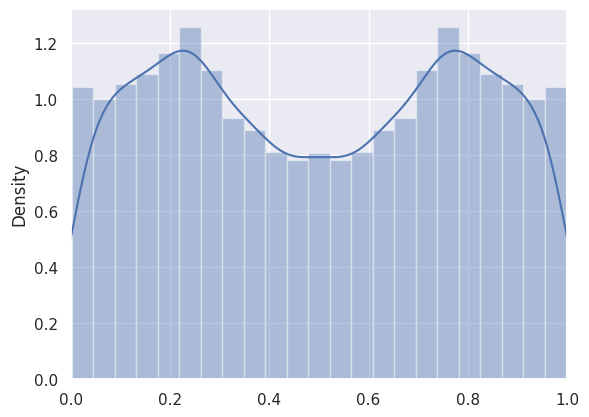

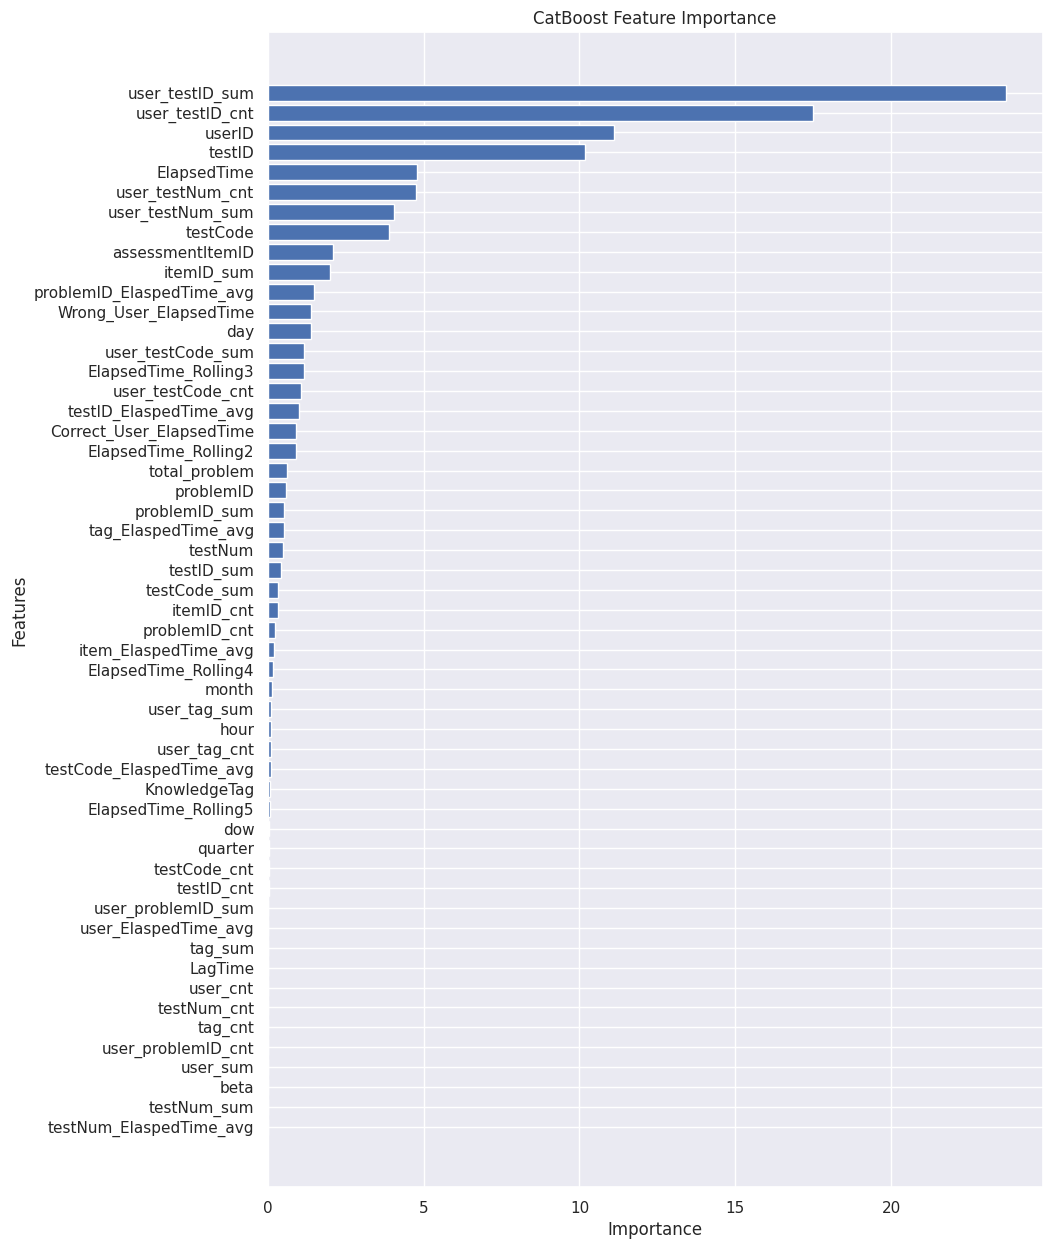

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Logloss,▁
ROC-AUC,▁
iteration@metric-period-1,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learn-Logloss,█▇▆▆▆▆▆▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
validation_0-AUC,▁▁▂▃▃▃▃▂▂▂▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇████████
validation_0-Logloss,█▇▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▂▂▃▃▃▂▂▂▂▂▁▁▁▁▁
validation_1-AUC,▁▂▄▅▆▆▆▇▇▇▇▇▇▇▇█████████████████▇▇▇▇▇▇▇▇
validation_1-Logloss,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂
Accuracy,0.75635
Logloss,0.49141


In [20]:
wandb.init(project = 'ML_ljw')
wandb.run.name = 'CAT_VS8_Feature53_CPU'
wandb.run.save()

train_data = Pool(data = X_train, label = y_train, cat_features = [col for col in X_train.select_dtypes('category').columns])
valid_data = Pool(data = X_valid, label = y_valid, cat_features = [col for col in X_train.select_dtypes('category').columns])

# Best Parameter 학습
# param = study.best_params
param = {'learning_rate': 0.1, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'} ## Best

cat_clf = CatBoostClassifier(**param, iterations = 5000, 
                             loss_function = 'Logloss', eval_metric = 'AUC',
                             use_best_model = True, random_state = SEED, # task_type = 'GPU', devices = '0',
                             cat_features = [X_train.columns.get_loc(col) for col in X_train.select_dtypes('category').columns])
cat_clf.fit(train_data, eval_set = [train_data, valid_data], verbose = 100, early_stopping_rounds = 100,
            callbacks = [CatBoostWandbCallback()])

# 모델 지표 출력
proba = cat_clf.predict_proba(X_valid)
roc_auc = roc_auc_score(y_valid, proba[:, 1])
accuracy = accuracy_score(y_valid, np.where(proba[:, 1] >= 0.5, 1, 0))
logloss = log_loss(y_valid, proba[:, 1])
print(f'ROC-AUC Score : {roc_auc:.4f} / Accuracy : {accuracy:.4f} / Logloss : {logloss:.4f}')
sns.distplot(proba) ; plt.xlim([0, 1]) ; plt.show()

# Feature Importance 출력
plt.figure(figsize = (10, 15))
importances = cat_clf.get_feature_importance(type = 'PredictionValuesChange') # LossFunctionChange
feature_importances = pd.Series(importances, index = X_train.columns).sort_values()
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance') ; plt.ylabel('Features') ; plt.show()

wandb.finish()

In [15]:
# cat_clf.load_model('./model/CAT_Feature91_0112')
# cat_clf.save_model('./model/CATCLF_Feature91_Wandb_0115')

394 / 744


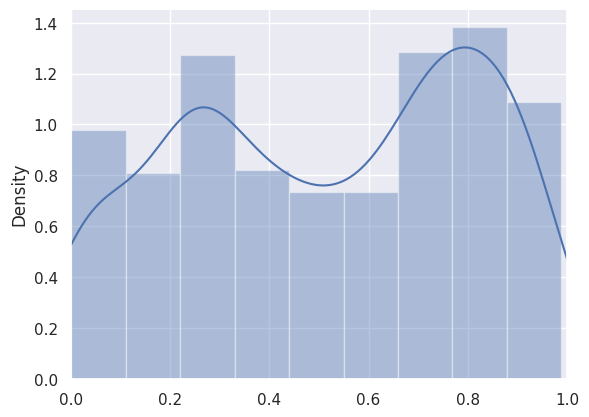

In [21]:
pred = cat_clf.predict(test_df)
proba = cat_clf.predict_proba(test_df)[:, 1]
print(f'{sum(pred)} / {len(pred)}')
sns.distplot(proba) ; plt.xlim([0, 1]) ; plt.show()

In [22]:
# SAVE OUTPUT
output_dir = '/data/ephemeral/submit/'
write_path = os.path.join(output_dir, 'CATCLF_VS8_Feature53_CPU.csv')
if not os.path.exists(output_dir) :
    os.makedirs(output_dir)
with open(write_path, 'w', encoding = 'utf8') as w :
    print('Writing Prediction : {}'.format(write_path))
    w.write('id,prediction\n')
    for id, p in enumerate(proba) :
        w.write('{},{}\n'.format(id, p))

Writing Prediction : /data/ephemeral/submit/CATCLF_VS8_Feature53_CPU.csv


## SelectFromModel

In [80]:
# train_data = Pool(data = X_train, label = y_train, cat_features = cat_col)
# valid_data = Pool(data = X_valid, label = y_valid, cat_features = cat_col)

# Best Parameter 학습
# param = study.best_params
param = {'learning_rate': 0.1, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'} ## Best

cat_clf = CatBoostClassifier(**param, iterations = 5000, 
                             loss_function = 'Logloss', eval_metric = 'AUC',
                             use_best_model = True, random_state = SEED, task_type = 'GPU', devices = '0',
                             cat_features = [X_train.columns.get_loc(col) for col in X_train.select_dtypes('category').columns])

In [81]:
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(estimator = cat_clf, threshold = 0.8 \
    ).fit(X_train, y_train, eval_set = [(X_valid, y_valid)], verbose = 300, early_stopping_rounds = 100)
print(f'Threshold : {selector.threshold_}')

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8113666	best: 0.8113666 (0)	total: 1.05s	remaining: 1h 27m 13s
bestTest = 0.8399555087
bestIteration = 115
Shrink model to first 116 iterations.
Threshold : 0.8


In [83]:
X_train_sel = pd.DataFrame(selector.transform(X_train), columns = selector.get_feature_names_out())
X_valid_sel = pd.DataFrame(selector.transform(X_valid), columns = selector.get_feature_names_out())
test_sel  = pd.DataFrame(selector.transform(test_df), columns = selector.get_feature_names_out())
print(X_train_sel.shape, y_train.shape, X_valid_sel.shape, y_valid.shape, test_sel.shape)

(2519258, 28) (2519258,) (6698, 28) (6698,) (744, 28)


In [88]:
cat_sel_col = ['userID', 'assessmentItemID', 'KnowledgeTag', 'testCode', 'testNum', 'is_correct_before1']
int_sel_col = ['user_cnt', 'user_testID_sum', 'user_testCode_cnt', 'itemID_sum', 'testID_cnt', 'testCode_sum']
flt_sel_col = ['ElapsedTime', 'testCode_ElaspedTime_avg', 'problemID_ElaspedTime_avg', 'tag_ElaspedTime_avg', 'Correct_User_ElapsedTime', 'Wrong_User_ElapsedTime',
               'user_acc', 'user_testID_acc', 'user_testCode_acc', 'itemID_acc', 'testID_acc', 'problemID_acc', 
               'correct_rate_before1', 'relative_correct_rate_before1', 'correct_rate_before2', 'relative_correct_rate_before2']

for col in tqdm.tqdm(cat_sel_col) :
    X_train_sel[col] = X_train_sel[col].astype('category')
    X_valid_sel[col] = X_valid_sel[col].astype('category')
    test_sel[col] = test_sel[col].astype('category')

for col in tqdm.tqdm(int_sel_col) :
    X_train_sel[col] = X_train_sel[col].astype('int32')
    X_valid_sel[col] = X_valid_sel[col].astype('int32')
    test_sel[col] = test_sel[col].astype('int32')

for col in tqdm.tqdm(flt_sel_col) :
    X_train_sel[col] = X_train_sel[col].astype('float64')
    X_valid_sel[col] = X_valid_sel[col].astype('float64')
    test_sel[col] = test_sel[col].astype('float64')

100%|██████████| 16/16 [00:00<00:00, 18.00it/s]


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8105677	best: 0.8105677 (0)	total: 784ms	remaining: 1h 5m 17s
bestTest = 0.8396823406
bestIteration = 180
Shrink model to first 181 iterations.
ROC-AUC Score : 0.8397 / Accuracy : 0.7565 / Logloss : 0.4920


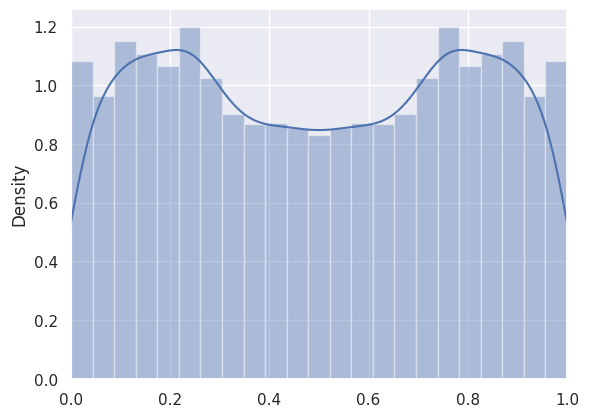

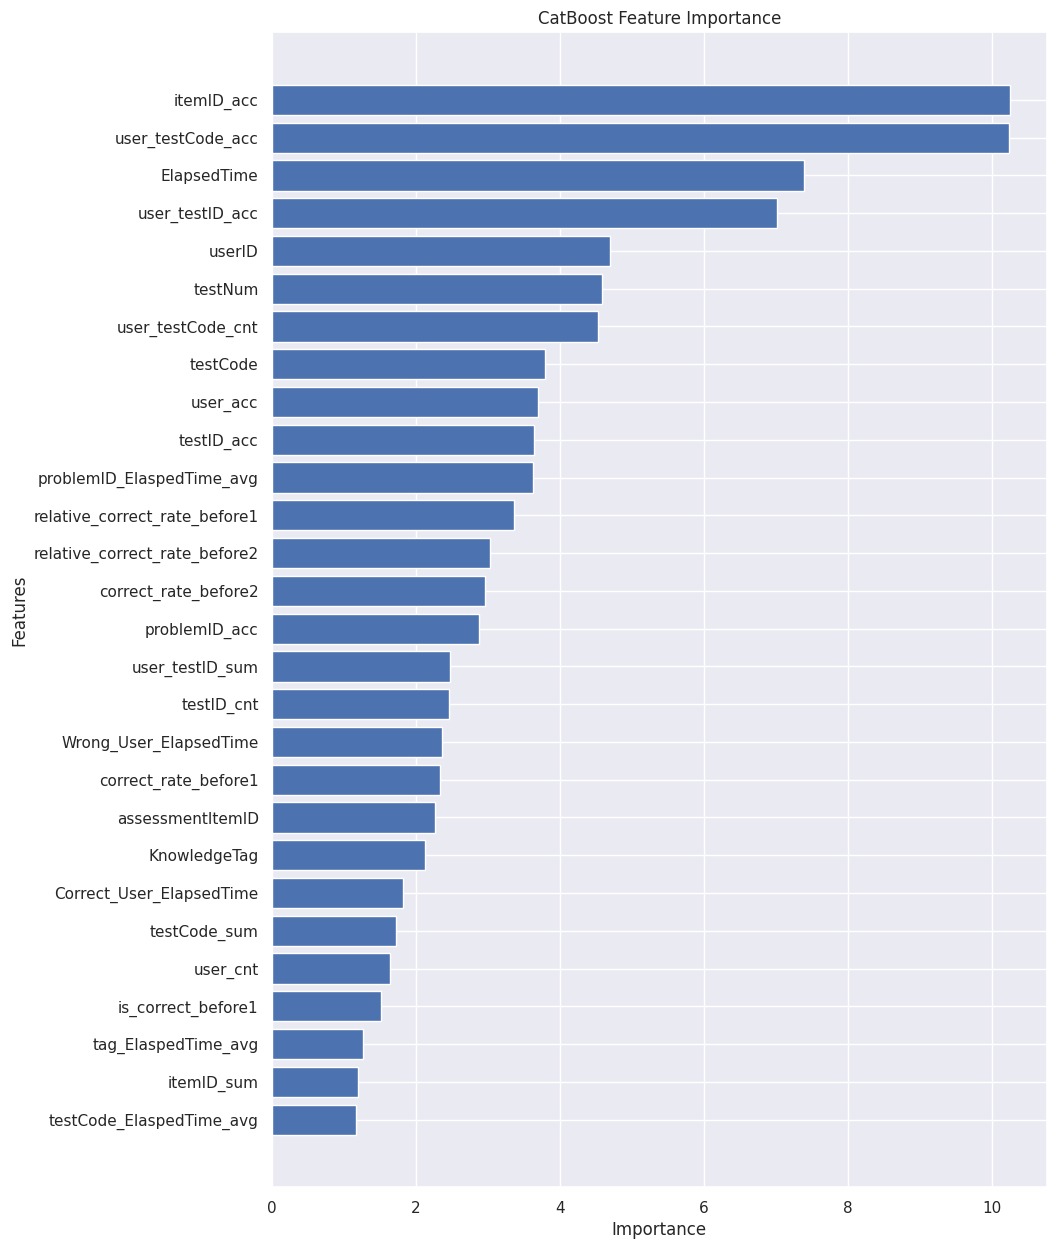

In [89]:
train_sel_data = Pool(data = X_train_sel, label = y_train, cat_features = cat_sel_col)
valid_sel_data = Pool(data = X_valid_sel, label = y_valid, cat_features = cat_sel_col)

# Best Parameter 학습
# param = study.best_params
param = {'learning_rate': 0.1, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'} ## Best

cat_clf = CatBoostClassifier(**param, iterations = 5000, 
                             loss_function = 'Logloss', eval_metric = 'AUC',
                             use_best_model = True, random_state = SEED, task_type = 'GPU', devices = '0',
                             cat_features = [X_train_sel.columns.get_loc(col) for col in X_train_sel.select_dtypes('category').columns])
cat_clf.fit(train_sel_data, eval_set = [valid_sel_data], verbose = 300, early_stopping_rounds = 100)
# train_data # callbacks = [CatBoostWandbCallback()]

# 모델 지표 출력
proba = cat_clf.predict_proba(X_valid_sel)
roc_auc = roc_auc_score(y_valid, proba[:, 1])
accuracy = accuracy_score(y_valid, np.where(proba[:, 1] >= 0.5, 1, 0))
logloss = log_loss(y_valid, proba[:, 1])
# wandb.log({'ROC-AUC' : roc_auc, 'Accuracy' : accuracy, 'Logloss' : logloss})
print(f'ROC-AUC Score : {roc_auc:.4f} / Accuracy : {accuracy:.4f} / Logloss : {logloss:.4f}')
sns.distplot(proba) ; plt.xlim([0, 1]) ; plt.show()

# Feature Importance 출력
plt.figure(figsize = (10, 15))
importances = cat_clf.get_feature_importance(type = 'PredictionValuesChange') # LossFunctionChange
feature_importances = pd.Series(importances, index = X_train_sel.columns).sort_values()
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance') ; plt.ylabel('Features') ; plt.show()
# wandb.finish()

368 / 744


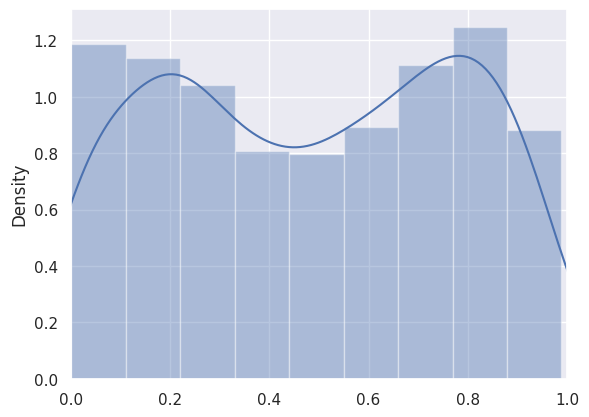

In [90]:
pred = cat_clf.predict(test_sel)
proba = cat_clf.predict_proba(test_sel)[:, 1]
print(f'{sum(pred)} / {len(pred)}')
sns.distplot(proba) ; plt.xlim([0, 1]) ; plt.show()

In [91]:
# SAVE OUTPUT
output_dir = '/data/ephemeral/submit/'
write_path = os.path.join(output_dir, 'CATCLF_SFM8_F28.csv')
if not os.path.exists(output_dir) :
    os.makedirs(output_dir)
with open(write_path, 'w', encoding = 'utf8') as w :
    print('Writing Prediction : {}'.format(write_path))
    w.write('id,prediction\n')
    for id, p in enumerate(proba) :
        w.write('{},{}\n'.format(id, p))

Writing Prediction : /data/ephemeral/submit/CATCLF_SFM8_F28.csv
